# Exoplanet Population Inference
## Josh Speagle (12/10/2016)

This notebook demonstrates how to perform exoplanet populaton inference building on the framework from [Foreman-Mackey, Hogg, & Morton (2014)](https://arxiv.org/abs/1406.3020) and well as the "demo" IPython Notebook included in this repository. The goal is to evaluate the frequency of Earth analogs given data from the *Kepler* spacecraft circa 2013 or so, although the by-product of this will be to derive the frequency of planets as a function of mass and radius.

Let's first initialize the environment to enable easier plotting and use of numerical Python packages and functions.

In [1]:
%pylab
%matplotlib inline
from IPython.display import display, Math, Latex
sys.path.insert(0, "./code")

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 26})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


We'll also need a couple system commands, as well as the code Foreman-Mackey has provided for this project.

In [2]:
import sys
import load_data

Finally, we'll want to import [**emcee**](http://dan.iel.fm/emcee/current/), the flexible Markov Chain Monte Carlo (MCMC) sampler developed by Foreman-Mackey et al. ([paper](https://arxiv.org/abs/1202.3665)).

In [3]:
import emcee

# Data

For this analysis, we'll use the catalog provided by [Petigura et al. (2013)](https://arxiv.org/abs/1311.6806). This contains the fitted results for a bunch of exoplanet *candidates*.

In [4]:
nstar = 42557. # total number of stars in dataset
_, data, _ = load_data.load_candidates() # load in planet candidate data (period,radius)
data = log(data) # convert to log-space
print 'N:', len(data)

N: 603


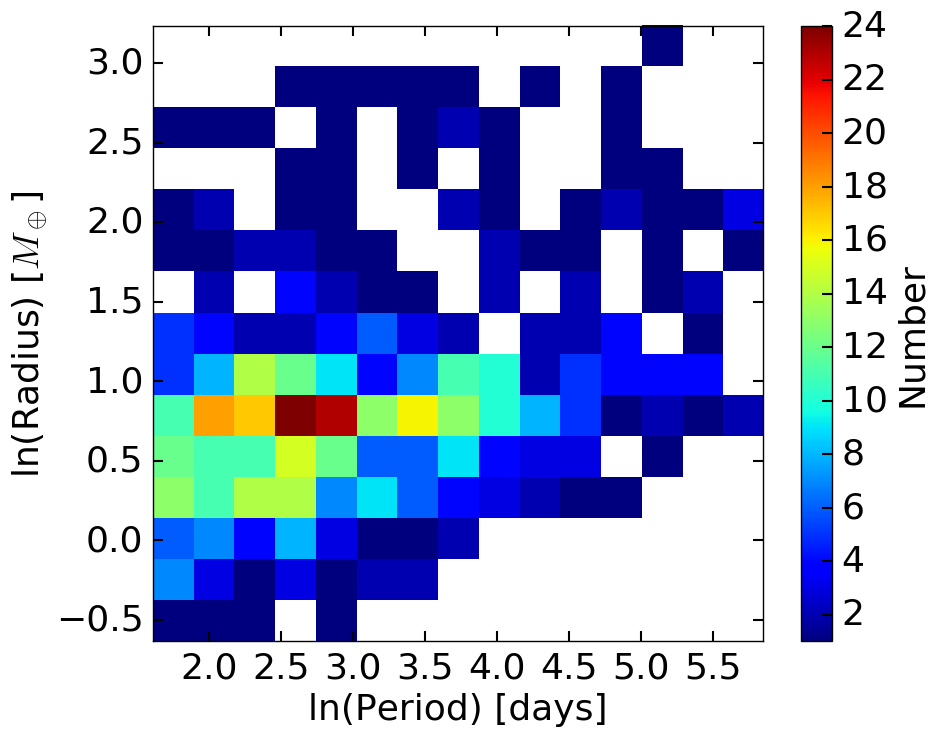

In [5]:
figure(figsize=(10, 8))
h = hist2d(data[:, 0], data[:, 1], bins=15, cmin=1)
xlabel('ln(Period) [days]')
ylabel('ln(Radius) [$M_\oplus$]')
colorbar(label='Number', ticks=arange(0, 50, 2))
tight_layout()

Only a certain number of planets will be used for this analysis, which are the ones in the range used for extrapolation.

In [6]:
lpmn, lpmx = log(50), log(400) # (min,max)=(50,400) bounds for period (days)
lrmn, lrmx = log(1), log(2) # (min,max)=(1,2) bounds for mass (Earth masses)

m = (lpmn < data[:, 0]) & (data[:, 0] < lpmx) & (lrmn < data[:, 1]) & (data[:, 1] < lrmx) # selection flag
data = data[m] # select planet subset within bounds
print 'N:', len(data)

N: 19


We also want to use binned representation of the detection probability map.

In [7]:
censor = load_data.load_detection_efficiency()

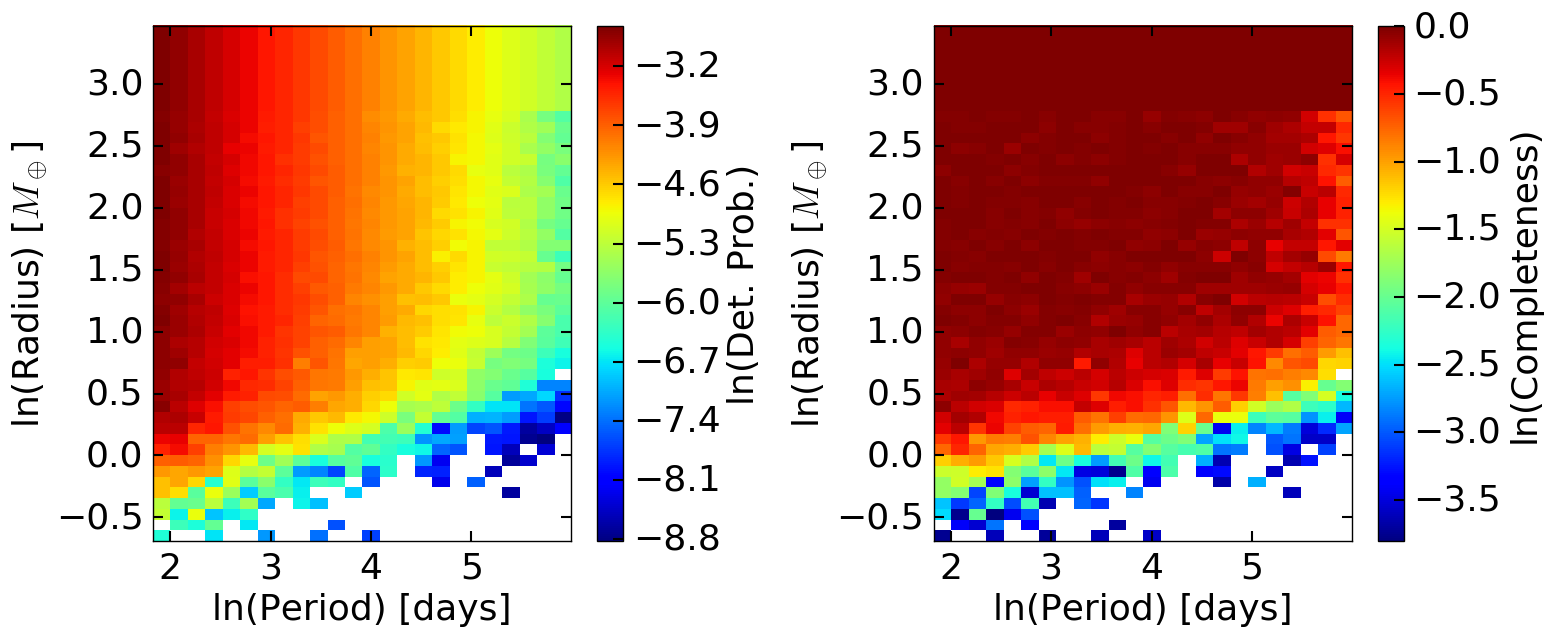

In [8]:
xx, yy = meshgrid(censor.bin_centers[0], censor.bin_centers[1]) # log(P,R) grid

figure(figsize=(16, 7))
subplot(1, 2, 1) # detection efficiency
h = hist2d(xx.ravel(), yy.ravel(), bins=censor.bins,
           weights=censor.lnprob[1:-1, 1:-1].swapaxes(0, 1).ravel())
colorbar(label='ln(Det. Prob.)', ticks=arange(-20, 0, 0.7))
xlabel('ln(Period) [days]')
ylabel('ln(Radius) [$M_\oplus$]')
locator_params(axis='x',nbins=8)
tight_layout()
subplot(1, 2, 2)
h = hist2d(xx.ravel(), yy.ravel(), bins=censor.bins,
           weights=censor.lncompleteness[1:-1 ,1:-1].swapaxes(0, 1).ravel())
colorbar(label='ln(Completeness)', ticks=arange(-10, 1, 0.5))
xlabel('ln(Period) [days]')
ylabel('ln(Radius) [$M_\oplus$]')
locator_params(axis='x',nbins=8)
tight_layout()

# Petigura et al. (2013): Our Starting Point

Petigura et al.'s analysis of this small subset of objects is straightforward and outlined below. First, we select the detection efficiency for each entry given our binned representation of the detection efficiency map.

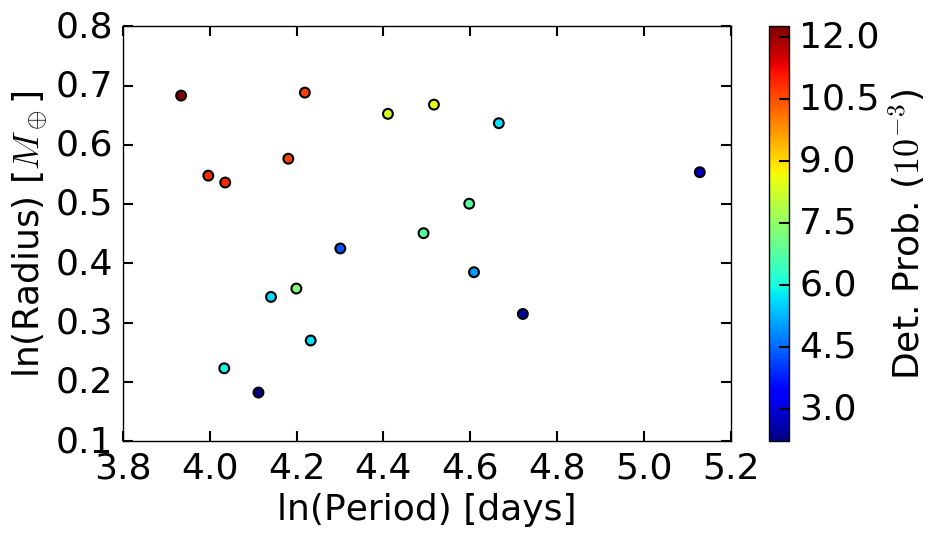

In [9]:
w = exp(censor.get_lnprob(data))

figure(figsize=(10, 6))
scatter(data[:, 0], data[:, 1], c=w*1e3, s=50, lw=1.5)
xlabel('ln(Period) [days]')
ylabel('ln(Radius) [$M_\oplus$]')
colorbar(label='Det. Prob. ($10^{-3}$)')
tight_layout()

Next we compute the 1-D cumulative distribution of the detection probability over the period (the cumulative period distribution, or "CPD").

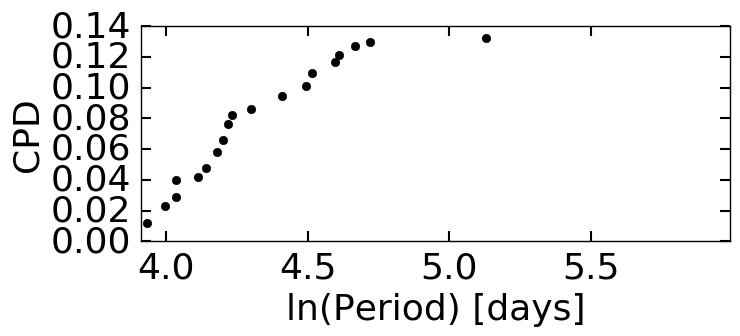

In [10]:
idx = data[:, 0].argsort() # sorted indices
cpd = w[idx].cumsum() # sorted cumulative sum of probabilities

figure(figsize=(8, 4))
plot(data[idx, 0], cpd, "ko")
xlabel('ln(Period) [days]')
ylabel('CPD')
xlim(lpmn, lpmx)
tight_layout()

This represents the cumulative probability of detecting a planet as a function of the period for objects with masses similar to the Earth (a total sample of 19 objects). This looks quasi-linear, which is the expected behavior of a **uniform distribution** over $\ln P$. This just has a constant probability distribution function (PDF) whose amplitude constrains $\Gamma_\oplus$, the occurence rate of planets with Earth-like masses and periods! Fitting a line thus gives access to the derivative,

\begin{equation}
\frac{d(\textrm{CPD})}{dP}=\Gamma_\oplus,
\end{equation}

and so is a direct probe of $\Gamma_\oplus$.

<IPython.core.display.Math object>

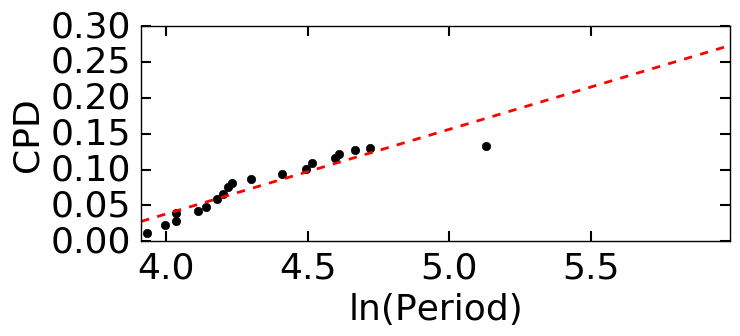

In [11]:
# linear fit
p = polyfit(data[idx, 0], cpd, 1)
x = linspace(lpmn, lpmx, 5000)

figure(figsize=(8, 4))
plot(data[idx, 0], cpd, "ko")
plot(x, polyval(p, x), "r--",lw=2)
xlabel('ln(Period)')
ylabel('CPD')
xlim(lpmn, lpmx)
tight_layout()

Math(r"\Gamma_\oplus = {0:.3f}".format(p[0]))

We can derive some rough error bars around this using bootstrap resampling, which is reasonably well-motivated here where we're not considering errors and we're dealing with low-number Poisson statistics.

In [12]:
gesamp=empty(10000) # samples

for i in xrange(10000):
    sel = randint(len(data),size=len(data)) # bootstrap resample
    dt, wt = data[sel], w[sel]
    idx = dt[:, 0].argsort() # sorted indices
    cpd = wt[idx].cumsum() # sorted cumulative sum of probabilities
    gesamp[i]=polyfit(dt[idx, 0], cpd, 1)[0] # \Gamma_earth sample

q1 = percentile(gesamp, [16, 50, 84])
e1 = diff(q1)
Math(r"\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}}".format(q1[1], e1[0], e1[1]))

<IPython.core.display.Math object>

This reproduces the value from Petigurra et al. 

We can visualize this distribution better by plotting up the full set of posterior draws. Rather than binning the output results using a histogram, I opt to instead use kernel density estimation (KDE) to try and reconstruct the underlying PDF.

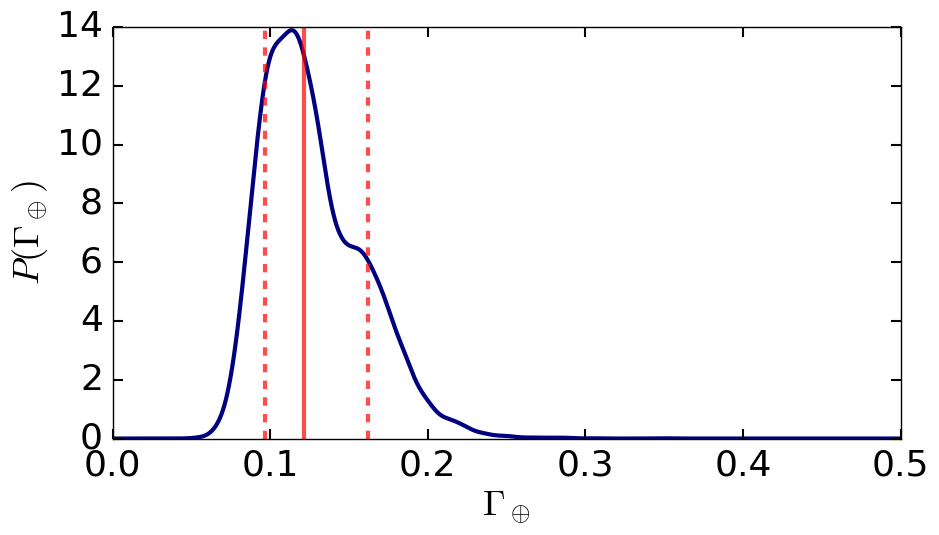

In [13]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.005).fit(gesamp[:,None]) # derive the underlying estimator
x = linspace(0, 0.5, 5000)
log_dens = kde.score_samples(x[:,None]) # return results

# plotting
figure(figsize=(10, 6))
plot(x, exp(log_dens), color='navy', lw=3)
axvline(q1[0], color='r', ls='--', alpha=0.7, lw=3)
axvline(q1[1], color='r', ls='-', alpha=0.7, lw=3)
axvline(q1[2], color='r', ls='--', alpha=0.7, lw=3)
xlabel('$\Gamma_\oplus$')
ylabel('$P(\Gamma_\oplus)$')
tight_layout()

It cannot be stressed enough that this linearity assumption is **extremely strong** given the perceived quality of the fit. For instance, we can fit this result with many other functional forms, all of which may give fits that are just as good and could have reasonably justified motivations. One example would be the monotonically increasing function

\begin{equation}
\textrm{CPD}(x)=a\ln(x+b)+c,
\end{equation}

where $a$, $b$, and $c$ are free parameters. We present such a fit below for comparison.

In [14]:
def logfit(x, a, b, c):
    return a*log(x+b) + c

<IPython.core.display.Math object>

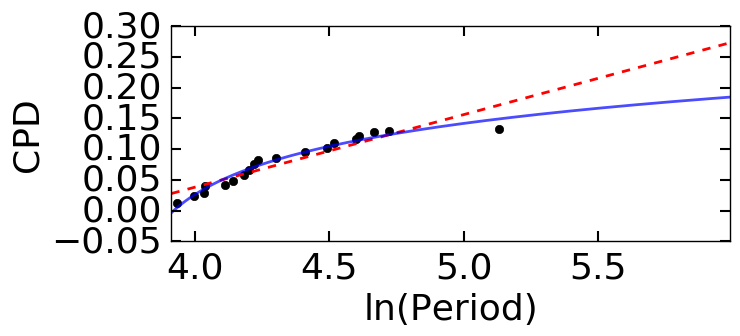

In [15]:
idx = data[:, 0].argsort() # sorted indices
cpd = w[idx].cumsum() # sorted cumulative sum of probabilities

# logarithmic fit (for comparison)
from scipy import optimize
p2, cov2 = optimize.curve_fit(logfit, data[idx, 0], cpd)
x = linspace(lpmn, lpmx, 5000)

figure(figsize=(8, 4))
plot(data[idx, 0], cpd, "ko")
plot(x, polyval(p, x), "r--",lw=2)
plot(x, logfit(x, p2[0], p2[1], p2[2]), "blue", lw=2, alpha=0.7)
xlabel('ln(Period)')
ylabel('CPD')
xlim(lpmn, lpmx)
tight_layout()

dcpd = p2[0] / (log(360.) + p2[1])
Math(r"\Gamma_\oplus = {0:.3f}".format(dcpd))

In [16]:
gesamp=empty(10000) # samples

for i in xrange(10000):
    sel = randint(len(data),size=len(data))
    dt, wt = data[sel], w[sel]
    idx = dt[:, 0].argsort() # sorted indices
    cpd = wt[idx].cumsum() # sorted cumulative sum of probabilities
    pt = optimize.curve_fit(logfit, dt[idx, 0], cpd, maxfev=100000)[0]
    gesamp[i] = pt[0] / (log(360.) + pt[1])

q2 = percentile(gesamp, [16, 50, 84])
e2 = diff(q2)
Math(r"\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}}".format(q2[1], e2[0], e2[1]))

<IPython.core.display.Math object>

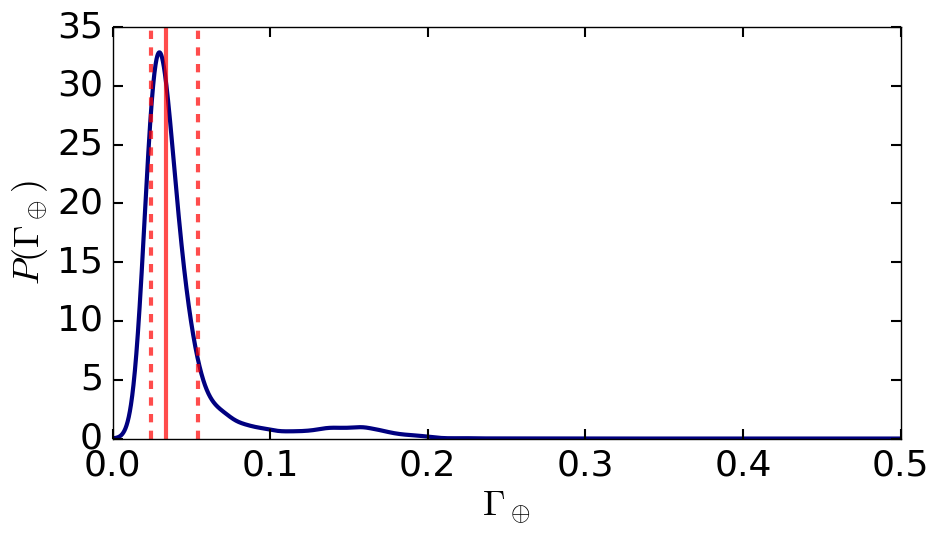

In [17]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.005).fit(gesamp[:,None]) # derive the underlying estimator
x = linspace(0, 0.5, 5000)
log_dens = kde.score_samples(x[:,None]) # return results

# plotting
figure(figsize=(10, 6))
plot(x, exp(log_dens), color='navy', lw=3)
axvline(q2[0], color='r', ls='--', alpha=0.7, lw=3)
axvline(q2[1], color='r', ls='-', alpha=0.7, lw=3)
axvline(q2[2], color='r', ls='--', alpha=0.7, lw=3)
xlabel('$\Gamma_\oplus$')
ylabel('$P(\Gamma_\oplus)$')
tight_layout()

Not only does adding one parameter significantly improve the fit, it also implies an estimate for $\Gamma_\oplus$ lower by a factor of $\sim 3.5$ with a very different posterior distribution.

# Petigura et al.: What "should" have been

Under the assumption of a flat (in log) bin in the range $1\,R_\oplus \le R < 2\,R_\oplus$ and $50\,\mathrm{days} \le P < 400\,\mathrm{days}$ (which we assumed above in our linear fit!), the **inverse-detection-efficiency approximation** for is

\begin{equation}
\Gamma = \frac{1}{\Delta} \sum_k \frac{1}{Q(\mathbf{w}_k)},
\end{equation}

where $\mathbf{w}_k$ are the physical parameters for object $k$ (i.e. $P$ and $R$), $\Delta$ is the area of the bin, and $Q$ is the total detection efficiency.

Assuming Poisson statistics apply here, we can derive an estimate of:

In [18]:
v = (1./w).sum() # sum of inverse detection probabilities
v /= ((lpmx - lpmn) * (lrmx - lrmn)) # normalize by bin area
v /= nstar # normalize by total number of stars in sample
ve = v/sqrt(len(data))
Math(r"\Gamma_\oplus = {0:.3f} \pm {1:.3f}".format(v, ve))

<IPython.core.display.Math object>

This is not a good estimate though, because the completeness evolves strongly across this bin, as shown below.

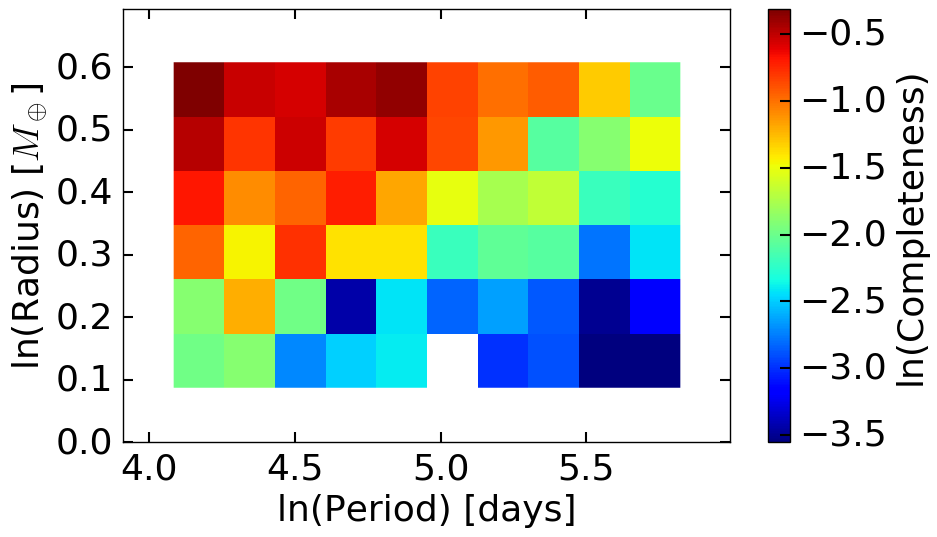

In [19]:
m1 = (lpmn < censor.bins[0]) & (censor.bins[0] < lpmx) # bounds (period)
m2 = (lrmn < censor.bins[1]) & (censor.bins[1] < lrmx) # bounds (radius)

figure(figsize=(10, 6))
h = hist2d(xx.ravel(), yy.ravel(), bins=[censor.bins[0][m1],censor.bins[1][m2]],
           weights=censor.lncompleteness[1:-1 ,1:-1].swapaxes(0, 1).ravel())
colorbar(label='ln(Completeness)', ticks=arange(-10, 1, 0.5))
xlim([lpmn,lpmx])
ylim([lrmn,lrmx])
xlabel('ln(Period) [days]')
ylabel('ln(Radius) [$M_\oplus$]')
tight_layout()

Evaluating the result based on the small amount of planet detections in this bin is thus a Bad Idea. Instead, as shown in Foreman-Mackey et al., the "correct" way to do this is actually integrate across the detection efficiency maps to compute

\begin{equation}
\Gamma = \frac{K}{\int_\Delta Q(\mathbf{w})\,\mathrm{d}\mathbf{w}},
\end{equation}

where $K$ is the number of objects within the bin. We can estimate $\int_\Delta Q(w)\,\mathrm{d}w$ using Monte Carlo methods as

\begin{equation}
\int_\Delta Q(\mathbf{w})\,\mathrm{d}\mathbf{w} \approx \frac{1}{N} \sum_{i=1}^N Q(\mathbf{w}_i)
\end{equation}

for a set of $\mathbf{w}_i$'s drawn uniformly from within the bin.

In [20]:
N = 100000 # number of samples
K = len(data)
samples = vstack([
        random.uniform(lpmn, lpmx, size=N),
        random.uniform(lrmn, lrmx, size=N)]).T # uniform samples in the bin
Q = exp(censor.get_lnprob(samples)) # detection efficiencies
Qint = mean(Q)*nstar # integrating and normalizing

In [21]:
# Compute the estimate of \Gamma.
mu = K / Qint
std = mu / sqrt(K)

Math(r"\Gamma_\oplus = {0:.3f} \pm {1:.3f}".format(mu, std))

<IPython.core.display.Math object>

This is consistent with the number from Petigura et al. above, but more rigorously derived.

# Relaxing Assumptions

Rather than assuming that the rate in a bin is **flat**, we can assume the next simplest functional form: a **linear model in $\ln P$** (with the caveat that it has to remain non-negative). This no longer gives a simple analytic solution, but the log-likelihood function for the model can be written as (borrowing from Foreman-Mackey):

\begin{equation}
\ln p(\{\ln P_k, \ln R_k\}\,|\,a,b) = -\int Q(\ln R \ln P)(a\ln P + b)\mathrm{d}(\ln R)\mathrm{d}(\ln P) + \sum_k \left[ \ln (a\ln(P_k)+b) + \ln Q(\ln R_k,\ln P_k) \right].
\end{equation}

We can sample from this distribution using emcee, where a set of uniform priors on $a$ and $b$ can be used to force the rate to always remain non-negative within the confines of our bin. We define these more explicitly below.

In [22]:
def model(p, lnp): # linear model
    return polyval(p, lnp - lpmn) # offset by minimum bound

def lnprior(p): # ln-prior
    if len(p) == 1: # for a one-parameter model
        if p[0] <= 0:
            return -inf # set p=0
    elif len(p) >= 2: # for a >two-parameter model
        if model(p, lpmn) < 0.0 or model(p, lpmx) < 0.0:
            return -inf # set p=0 
        if len(p) > 2: # if we have a more complicated model with >2 parameters
            x = -0.5 * p[1] / p[0]
            if lpmn <= x < lpmx and model(p, x) < 0.0: # if ratio is within bounds and model is negative
                return -inf # set p=0
    return 0.0

def lnlike(p): # ln-likelihood
    norm = mean(model(p, samples[:, 0]) * Q) # normalization (relative to precomputed Q)
    ll = sum(log(model(p, data[:, 0])) + censor.get_lnprob(data)) # log-likelihood
    return ll - norm

def lnprob(p): # ln-posterior
    lp = lnprior(p) # ln-prior
    if not isfinite(lp): # if things blew up
        return -inf # posterior is zero
    ll = lnlike(p) # ln-likelihood
    if not isfinite(ll): # if things blew up
        return -inf # likelihood is zero
    return lp + ll # posterior term

We'll now initialize emcee.

In [23]:
nwalkers = 36 # number of walkers
p0 = random.multivariate_normal([0, 5000.], diag([1e-2, 1e-2]), size=nwalkers) # intialize walkers
ndim = p0.shape[1] # dimensionality
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob) # initialize sampler

In [24]:
p0, _, _ = sampler.run_mcmc(p0, 500) # burn-in

sampler.reset() 
sampler.run_mcmc(p0, 1000); # sample from posterior

Our posterior constraints on the output density are shown below, with the uniform estimate and the period of the Earth indicated in dashed black and red, respectively.

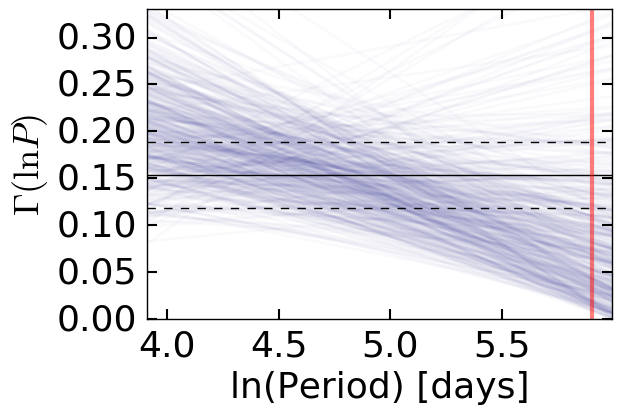

In [25]:
x = linspace(lpmn, lpmx, 500)
chain = sampler.flatchain # combine walkers to create single flattened chain

# plot draws
for i in random.randint(len(chain), size=500): # draw 500 random samples
    plot(x, model(chain[i], x) / nstar, color="navy", lw=2, alpha=0.02)

# plot uniform estimate
axhline(mu, color='k')
axhline(mu+std, color='k', ls='--')
axhline(mu-std, color='k', ls='--')

# plot Earth value
axvline(log(365.), color='r', alpha=0.5, lw=3)

xlim(lpmn, lpmx)
ylim(0, 0.33)
xlabel('ln(Period) [days]')
ylabel('$\Gamma(\ln P)$')

At the location of Earth, these two results are in tension, indicating that the data don't fully support a uniform distribution. We quantify this below by examing the distribution of our output fits.

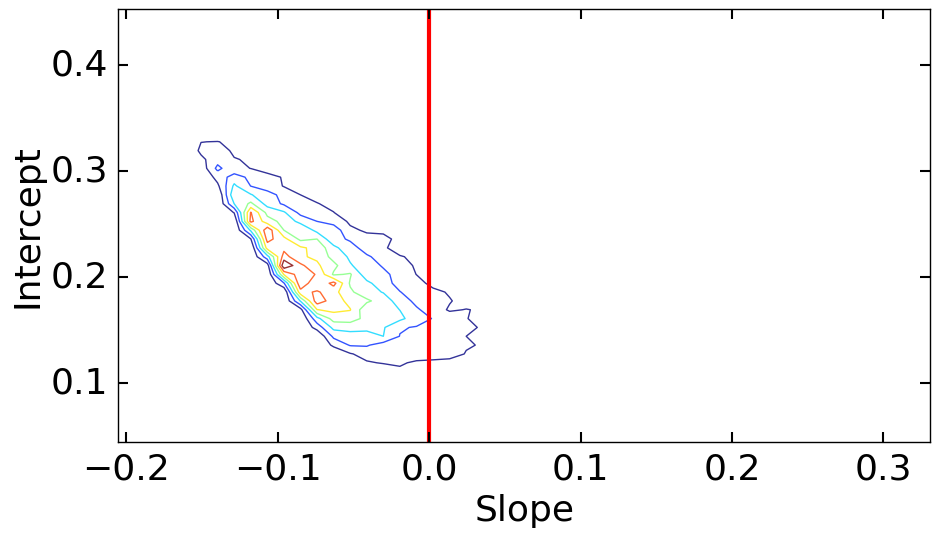

In [26]:
figure(figsize=(10, 6))
hh, xx, yy = histogram2d((chain/nstar)[:,0], (chain/nstar)[:,1], bins=50)
contour((xx[1:]+xx[:-1])*0.5, (yy[1:]+yy[:-1])*0.5, hh.swapaxes(0,1), alpha=0.8)
axvline(0, color='r', lw=3)
xlabel('Slope')
ylabel('Intercept')
tight_layout()

Using these samples, we can compute the constraint on $\Gamma_\oplus$:

In [27]:
ge = array([model(p, log(365.)) for p in chain]) # \Gamma_earth from all samples
ge /= nstar # normalizing by size of sample

q3 = percentile(ge, [16, 50, 84]) # compute 16th, 50th, and 84th (i.e. 1-sigma) confidence intervals
e3 = diff(q3) # grab bounds
Math(r"\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}}".format(q3[1], e3[0], e3[1]))

<IPython.core.display.Math object>

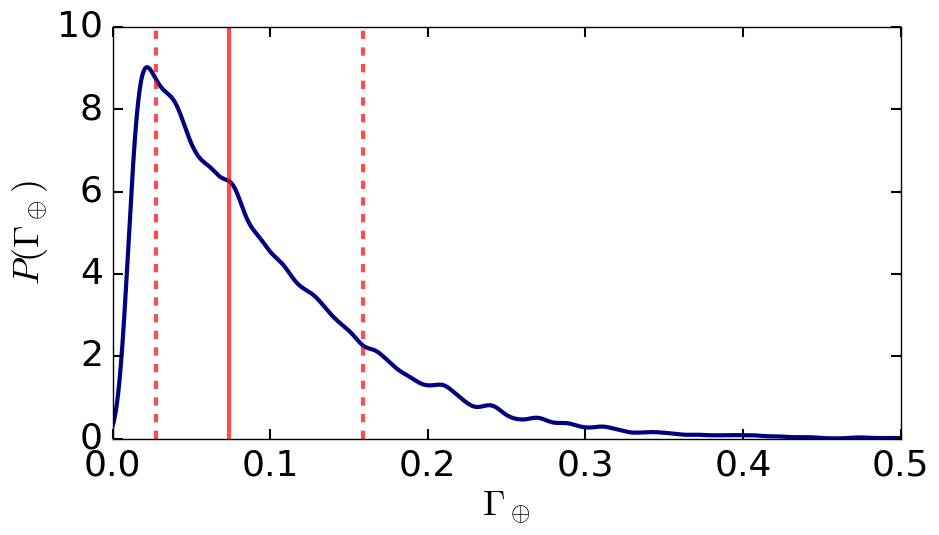

In [28]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.005).fit(ge[:,None]) # derive the underlying estimator
x = linspace(0, 0.5, 5000)
log_dens = kde.score_samples(x[:,None]) # return results

# plotting
figure(figsize=(10, 6))
plot(x, exp(log_dens), color='navy', lw=3)
axvline(q3[0], color='r', ls='--', alpha=0.7, lw=3)
axvline(q3[1], color='r', ls='-', alpha=0.7, lw=3)
axvline(q3[2], color='r', ls='--', alpha=0.7, lw=3)
xlabel('$\Gamma_\oplus$')
ylabel('$P(\Gamma_\oplus)$')
tight_layout()

For reference, Petigura et al.'s result is:

In [29]:
Math(r"\Gamma_\oplus = {0:.3f} \pm {1:.3f}".format(mu, std))

<IPython.core.display.Math object>

If we now integrating these results over Petigura et al.'s bin (which ranges from $200<P<400$ rather than the bounds we used earlier), we get:

In [30]:
area = (lrmx - lrmn) * (log(400) - log(200))
Math(r"\Gamma_{{\oplus,\mathrm{{int}}}} = {0:.3f} \pm {1:.3f} \quad (\mathrm{{uniform}})".format(mu*area, std*area))

<IPython.core.display.Math object>

In [31]:
q = percentile(ge*area, [16, 50, 84])
e = diff(q)
Math(r"\Gamma_{{\oplus,\mathrm{{int}}}} = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}} \quad (\mathrm{{linear}})"
     .format(q[1], e[0], e[1]))

<IPython.core.display.Math object>

# Dong & Zhu: Parametric Modeling

[Dong & Zhu (2013)](https://arxiv.org/abs/1212.4853) fit a model of the form

\begin{equation}
\Gamma (\log P,\log R) = C\left(\frac{P}{10\,\mathrm{days}}\right)^{\beta}.
\end{equation}

Over the same range of $1\,R_\oplus \le R < 2\,R_\oplus$, they found that

\begin{equation}
C = 0.66 \pm 0.08, \quad \beta = -0.10 \pm 0.12.
\end{equation}

For

\begin{equation}
\Gamma (\ln P,\,\ln R) = \frac{1}{(\ln 10)^2} \Gamma (\log P,\log R),
\end{equation}

$\Gamma_\oplus$ is then:

In [32]:
N = 100000
C = 0.66 + 0.08*randn(N)
beta = -0.10 + 0.12*randn(N)
vals = C*(365./10)**beta / log(10)**2
q4 = percentile(vals, [16, 50, 84])
e4 = diff(q4)
Math(r"\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}}".format(q4[1], e4[0], e4[1]))

<IPython.core.display.Math object>

# General Model: Synthetic Data

We now want to generalize our results to the model from Forema-Mackey et al. Following them, we want to test our results on some synthetic data first before moving onto the "real deal". We start by generating two catalogs: one with smoothing (i.e. catalog "A") and one without (i.e. catalog "B").

In [33]:
import simulate_cat

In [34]:
print 'N(A):', simulate_cat.sim('data/','smooth',smooth=True)
print 'N(B):', simulate_cat.sim('data/','rough',smooth=False)

N(A): 429
N(B): 478


Now it's time to move onto the general analysis. Let's first start with some basic packages we'll need to manage outputs and make some figures.

In [35]:
import h5py
import corner
import cPickle as pickle

The meat of this analysis is going to be the underlying probabilistic model: a **Gaussian Process**! We'll use DFM's version for our analysis here.

In [36]:
from population import ProbabilisticModel, Dataset, Population

## V-Max Estimation

Let's now analyze our synthetic data with a V-Max estimator (i.e. a binned estimate), which ignores measurement errors and is the maximum-likelihood solution. This is the binned way of doing things without using a GP.

Because we're working fundamentally in a binned space, we want to ensure our bins are large enough to contain a reasonable number of objects. We thus downsample the original map by a factor of 4.

In [37]:
lpb, lrb = censor.bins # original bins
x, y = lpb[::4], lrb[::4] # downsample
bins = [x, y] # new bins
pop = Population(bins, censor.bins, 11.0) # initialize our population
print 'Bins:',x.shape[0],'(ln P) x',y.shape[0],'(ln R)'

Bins: 7 (ln P) x 13 (ln R)


### Catalog A (smoothed prior)

Let's load in our data.

In [38]:
catalog, err, truth = pickle.load(open("data/smooth.cat.pkl", 'rb')) # load catalog
rerr = [log(catalog[:, 1]) - log(catalog[:, 1]-err[:, 1]),
        log(catalog[:, 1]+err[:, 1]) - log(catalog[:, 1])] # radius error
err = [0, rerr] # period and radius errors

And now we compute our results!

In [39]:
from analysis import inverse_detection_efficiency
v, val, var, literature, mvn, cdf = inverse_detection_efficiency(pop, censor, catalog, truth)

We can visualize these results using a weighted 2-D histogram.

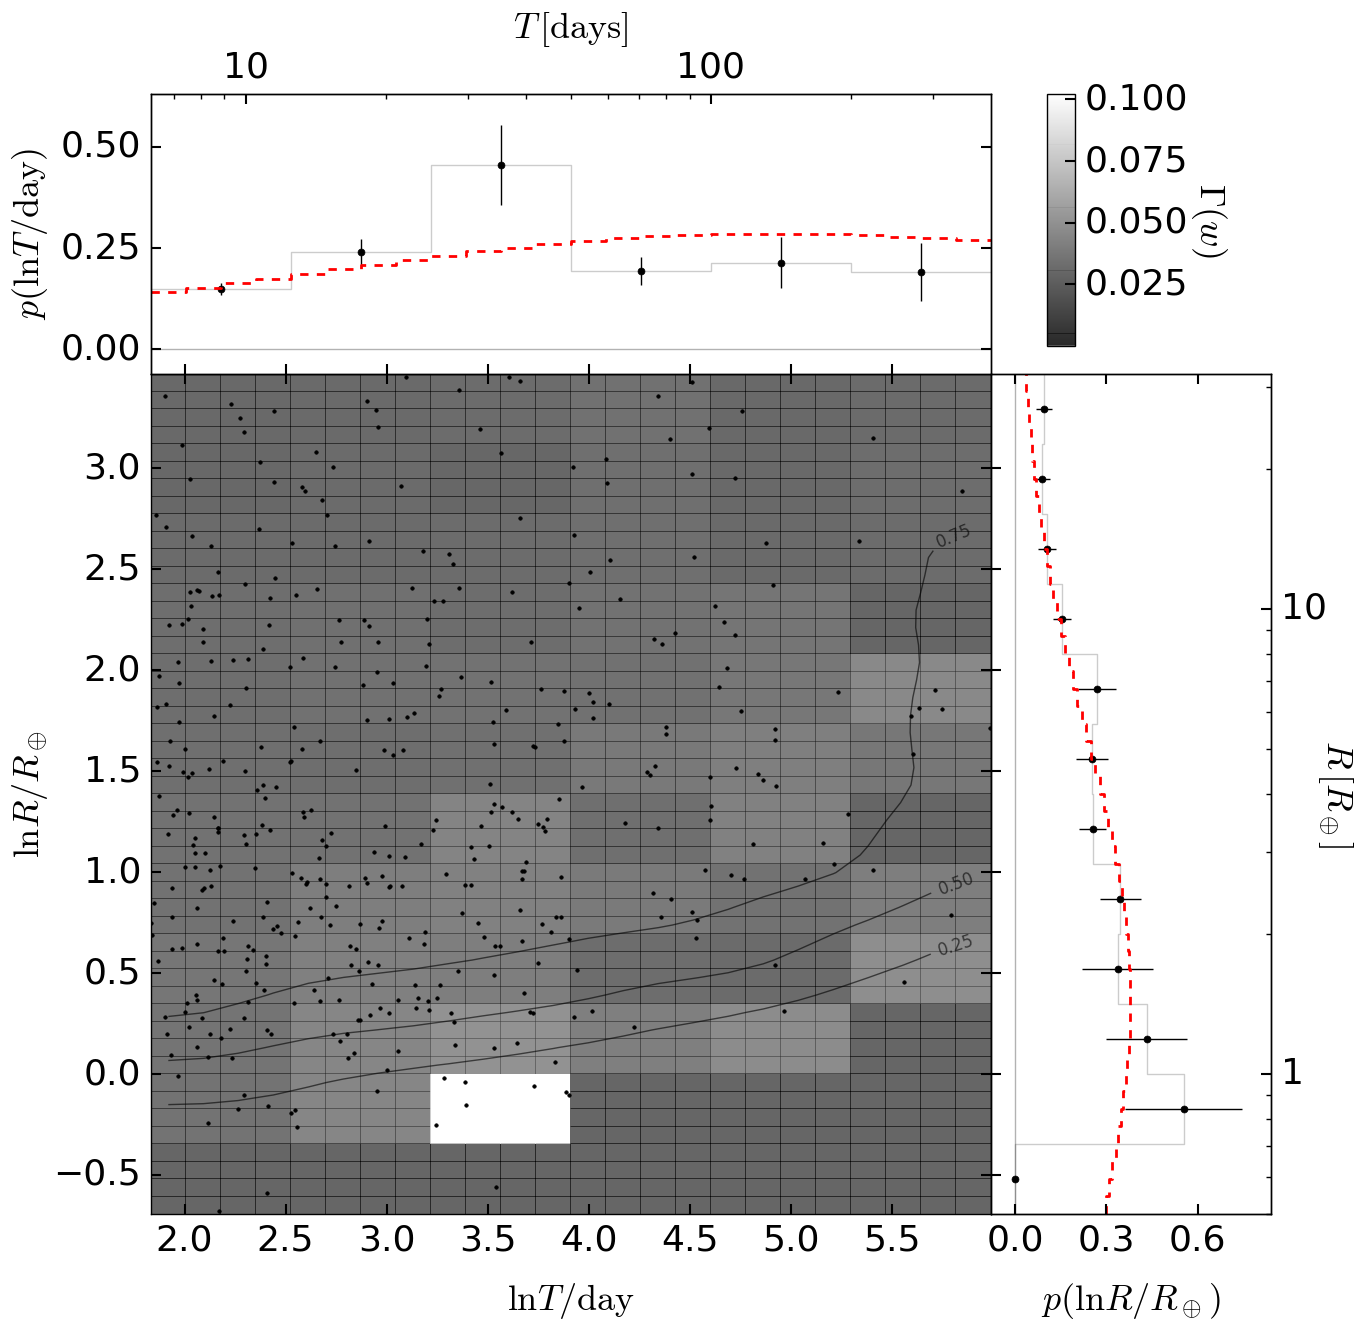

In [40]:
labels = ["$\ln T/\mathrm{day}$", "$\ln R/R_\oplus$"]
top_axes = ["$T\,[\mathrm{days}]$", "$R\,[R_\oplus]$"]
fig1 = pop.plot_2d(v-log(nstar), censor=censor, catalog=log(catalog),
                   err=None, true=truth, labels=labels,
                   top_axes=top_axes, literature=literature)

Now let's examine how well we do if we try to extrapolate our fits linearly using the mean and covariance matrices derived from our bins.

<IPython.core.display.Math object>

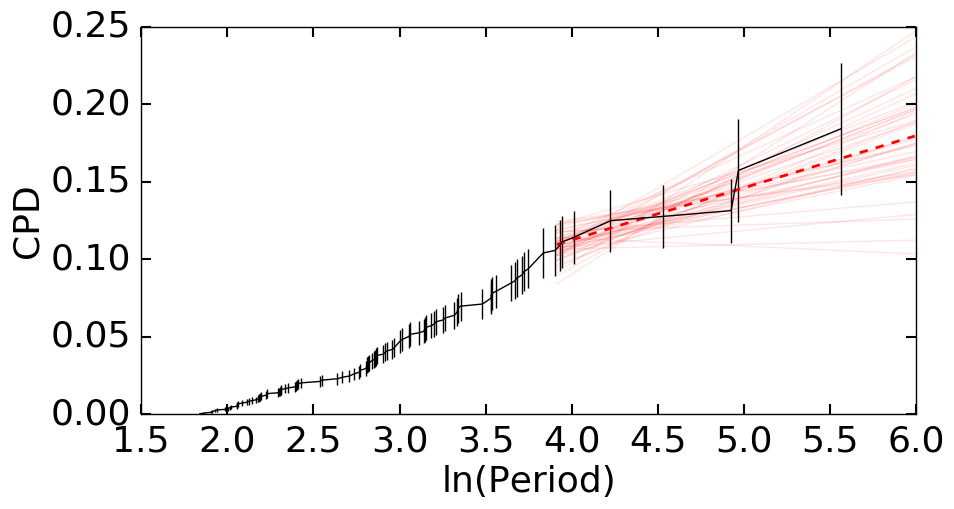

In [41]:
# predict values
ys = dot(array([[log(200), 1], [log(400), 1]]), # locations to sample
         multivariate_normal(mvn[0], mvn[1], 5000).T) # compute samples from multivariate normal
frac = diff(ys, axis=0) # turn cdf into pdf
q = corner.quantile(frac, [0.16, 0.5, 0.84]) # grab quantiles
e = diff(q)

# plot results
figure(figsize=(10, 5))
a = vander(linspace(log(50), log(400), 500), 2) # compute (x^1, x^2)
y = dot(a, multivariate_normal(mvn[0], mvn[1], 50).T) # compute samples
plot(a[:, 0], y/nstar, "r", alpha=0.1)
plot(a[:, 0], dot(a, mvn[0])/nstar, "--r", lw=2)
errorbar(cdf[0], cdf[1]/nstar, yerr=sqrt(cdf[2])/nstar, fmt="k", capsize=0)
xlabel('ln(Period)')
ylabel('CPD')
Math(r"\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}}".format(q[1]/nstar, e[0]/nstar, e[1]/nstar))

### Catalog B (unsmoothed prior)

Let's now do the same for B.

In [43]:
catalog, err, truth = pickle.load(open("data/rough.cat.pkl", 'rb')) # load catalog
rerr = [log(catalog[:, 1]) - log(catalog[:, 1]-err[:, 1]),
        log(catalog[:, 1]+err[:, 1]) - log(catalog[:, 1])] # radius error
err = [0, rerr] # period and radius errors

In [44]:
v, val, var, literature, mvn, cdf = inverse_detection_efficiency(pop, censor, catalog, truth)

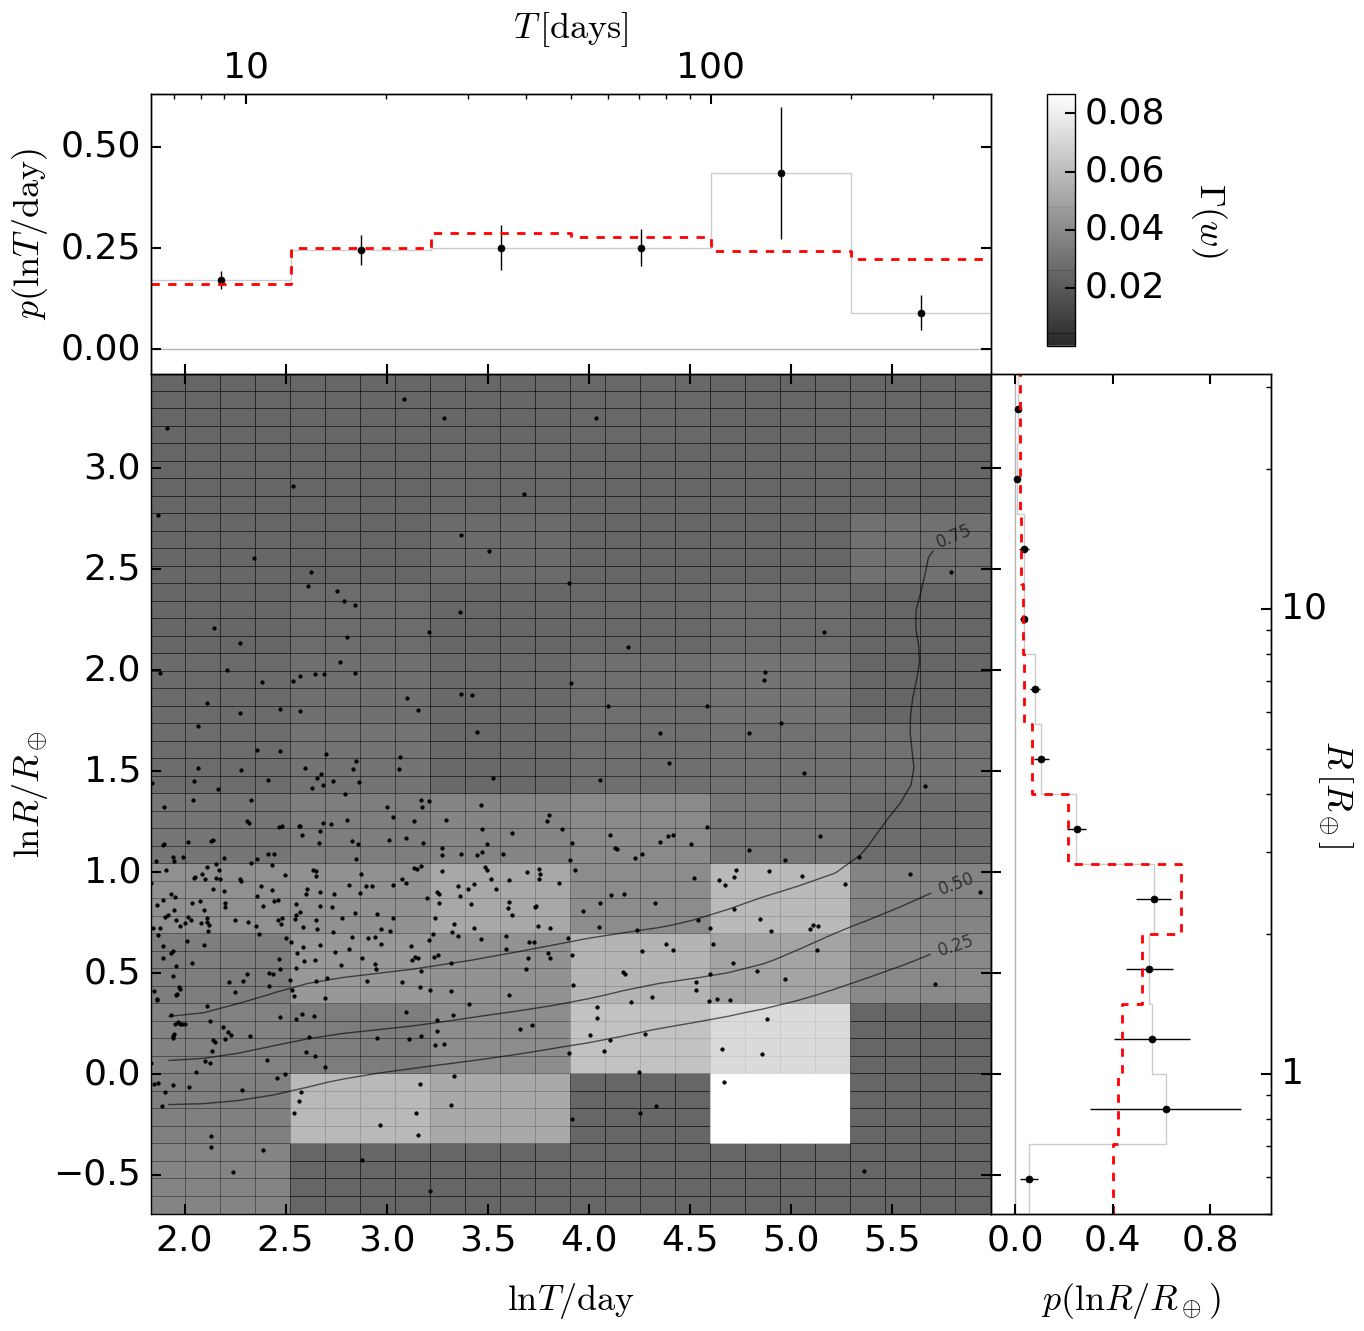

In [45]:
fig1 = pop.plot_2d(v-log(nstar), censor=censor, catalog=log(catalog),
                   err=None, true=truth, labels=labels,
                   top_axes=top_axes, literature=literature)

<IPython.core.display.Math object>

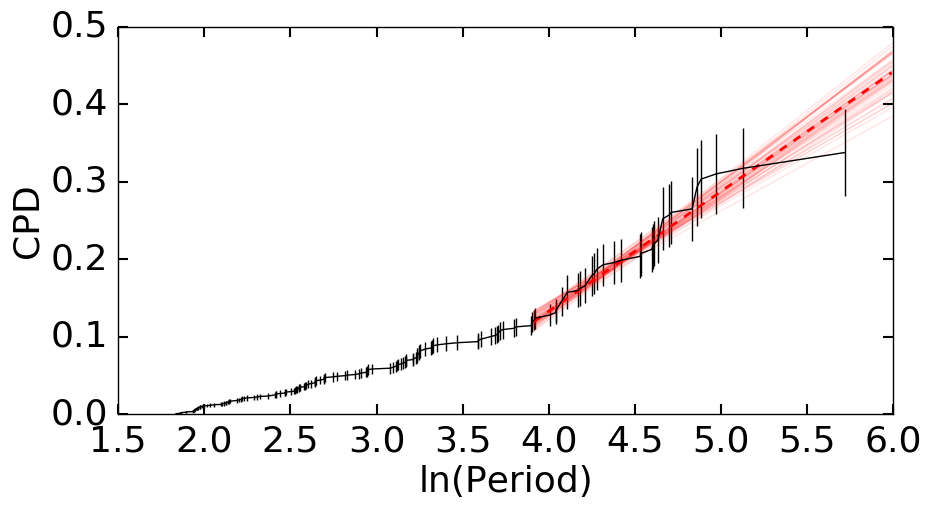

In [46]:
# predict values
ys = dot(array([[log(200), 1], [log(400), 1]]), # locations to sample
         multivariate_normal(mvn[0], mvn[1], 5000).T) # compute samples from multivariate normal
frac = diff(ys, axis=0) # turn cdf into pdf
q = corner.quantile(frac, [0.16, 0.5, 0.84]) # grab quantiles
e = diff(q)

# plot results
figure(figsize=(10, 5))
a = vander(linspace(log(50), log(400), 500), 2) # compute (x^1, x^2)
y = dot(a, multivariate_normal(mvn[0], mvn[1], 50).T) # compute samples
plot(a[:, 0], y/nstar, "r", alpha=0.1)
plot(a[:, 0], dot(a, mvn[0])/nstar, "--r", lw=2)
errorbar(cdf[0], cdf[1]/nstar, yerr=sqrt(cdf[2])/nstar, fmt="k", capsize=0)
xlabel('ln(Period)')
ylabel('CPD')
Math(r"\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}}".format(q[1]/nstar, e[0]/nstar, e[1]/nstar))

The large systematic variation in these two estimates is what motivates going to a fully probabilistic model!

## Probabilistic Estimation

Now we want to incorporate measurement uncertainties into our model more explicitly using a GP over the bins.

In [48]:
K=512 # number of samples

### Outline

In [49]:
fname="data/smooth"
catalog, err, truth = pickle.load(open(fname+".cat.pkl", 'rb')) # load catalog
dataset = Dataset.sample(catalog, err, samples=K, censor=censor, functions=[log, log]) # generate realization(s)
rerr = [log(catalog[:, 1]) - log(catalog[:, 1]-err[:, 1]),
        log(catalog[:, 1]+err[:, 1]) - log(catalog[:, 1])] # radius error
err = [0, rerr] # period and radius errors
v, val, var, literature, mvn, cdf = inverse_detection_efficiency(pop, censor, catalog, truth)

We now initialize our probabilistic model and dump it to disk.

In [50]:
# initialize model (initial conditions set by DFM)
model = ProbabilisticModel(dataset, pop, censor, [3.6, 2.6, 1.6, 0.0], array([2.0, 0.5, 0.3, 0.3]) / 2.4) 

# dump model
pickle.dump((model, catalog, err, truth, labels, top_axes, literature),
            open(fname+".model.pkl", "w"), -1)

Now comes to hard part: sampling the underlying distribution. The code that we *can* use to do this is shown below, but I wouldn't run it unless you want to spend a long time waiting for samples.

In [51]:
#nblock = 500
#N, ndim, nhyper = 2000 * nblock, len(pop), 4
#
#samples = empty((nblock, ndim))
#hyper = empty((nblock, nhyper))
#lnprob = empty(nblock)
#
#fn = fname+".results.h5"
#with h5py.File(fn, "w") as f:
#    f.create_dataset("samples", shape=(N, ndim), dtype=float64)
#    f.create_dataset("hyper", shape=(N, nhyper), dtype=float64)
#    f.create_dataset("lnprob", shape=(N,), dtype=float64)
#
#for i, (th, hy, lp, acc) in enumerate(model.sample()):
#    n = i % nblock
#    samples[n, :] = th
#    hyper[n, :] = hy
#    lnprob[n] = lp
#    if n == nblock - 1:
#        print i+1, (i+1.) / N, max(lnprob), acc
#        s = slice(i-n, i+1)
#        with h5py.File(fn, "a") as f:
#            f.attrs["iteration"] = i+1
#            f["samples"][s, :] = samples
#            f["hyper"][s, :] = hyper
#            f["lnprob"][s] = lnprob
#
#    if i >= N-1:
#        break

## Foreman-Mackey et al.'s Results

Instead, DFM has graciously made the results from the paper [public](https://zenodo.org/record/11507#.WEtroPkrKUk). So we'll use those instead. These are a set of draws from the occurrence rate bins and hyperparameters, along with the bins used for the analysis.

### Catalog A

In [52]:
with h5py.File("data/dfm-exopop-results-7568693/simulated/catalog-a/samples.h5") as f:
    samples = f["ln_occurrence_rate_samples"][:, :]
    hyper = f["hyperparameter_samples"][:, :]
    x = f["ln_period_bin_edges"][:]
    y = f["ln_radius_bin_edges"][:]

We have four hyperparameters in our model: the mean $\mu\mathbf{1}$ of the distribution, the correlation amplitude $\lambda_0$, and the correlation length scales $\lambda_P$ and $\lambda_R$ in period and radius, respectively (assuming both were uncorrelated).

Hyperparameter values (2ln):
5.82237106037 - 2.29818047326 + 1.31855869451
1.3593660634 - 1.04272012809 + 1.05279099171
3.51162724381 - 0.925276485876 + 1.10811068453
1.69742660295 - 0.660306741089 + 0.634341740806


Hyperparameter values (linear):
18.378574011 - 12.5539447749 + 17.1545924537
1.97325217471 - 0.80170766664 + 1.36710776056
5.7881551965 - 2.14381481765 + 4.28495090955
2.33663836769 - 0.657031175678 + 0.872120363421


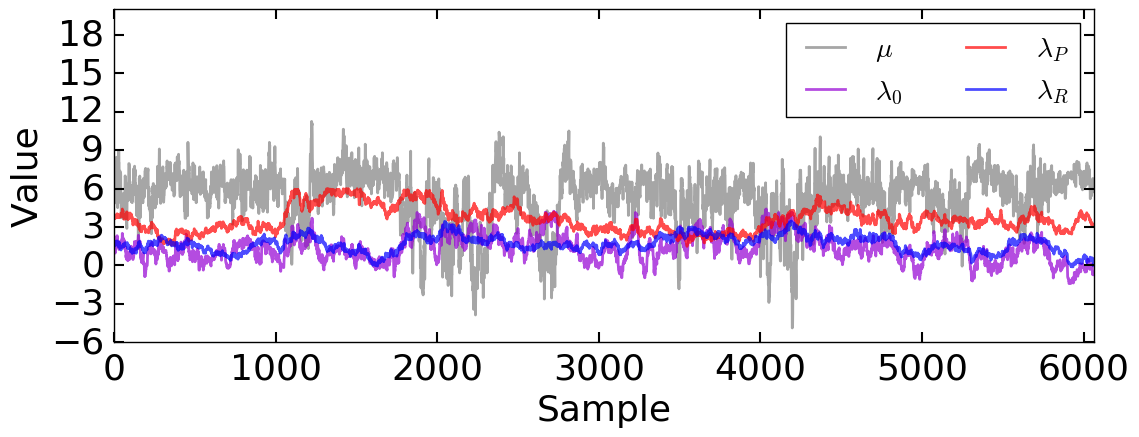

In [53]:
def xmap(f, i):
    return (f(*x) for x in i)

hypernames = ['$\mu$', '$\lambda_0$', '$\lambda_P$', '$\lambda_R$']
hypercolors = ['gray', 'darkviolet', 'red', 'blue']
figure(figsize=(12, 5))
for i in range(hyper.shape[1]):
    plot(hyper[:, i], label=hypernames[i], color=hypercolors[i], lw=2, alpha=0.7)
xlabel('Sample')
xlim([0, len(hyper)])
yticks(arange(-6, 20, 3))
ylim([-6, 20])
ylabel('Value')
legend(loc="best", fontsize=20, ncol=2)
tight_layout()

print("Hyperparameter values (2ln):")

q=array([corner.quantile(hyper[:, i], [.16, .50, .84]) for i in xrange(hyper.shape[1])])
e=diff(q)
print("\n".join(xmap("{0} - {1} + {2}".format, zip(q[:,1], e[:,0], e[:,1]))))

print("\n")
print("Hyperparameter values (linear):")

q=array([corner.quantile(exp(0.5*hyper[:, i]), [.16, .50, .84]) for i in xrange(hyper.shape[1])])
e=diff(q)
print("\n".join(xmap("{0} - {1} + {2}".format, zip(q[:,1], e[:,0], e[:,1]))))

Let's now plot up our results!

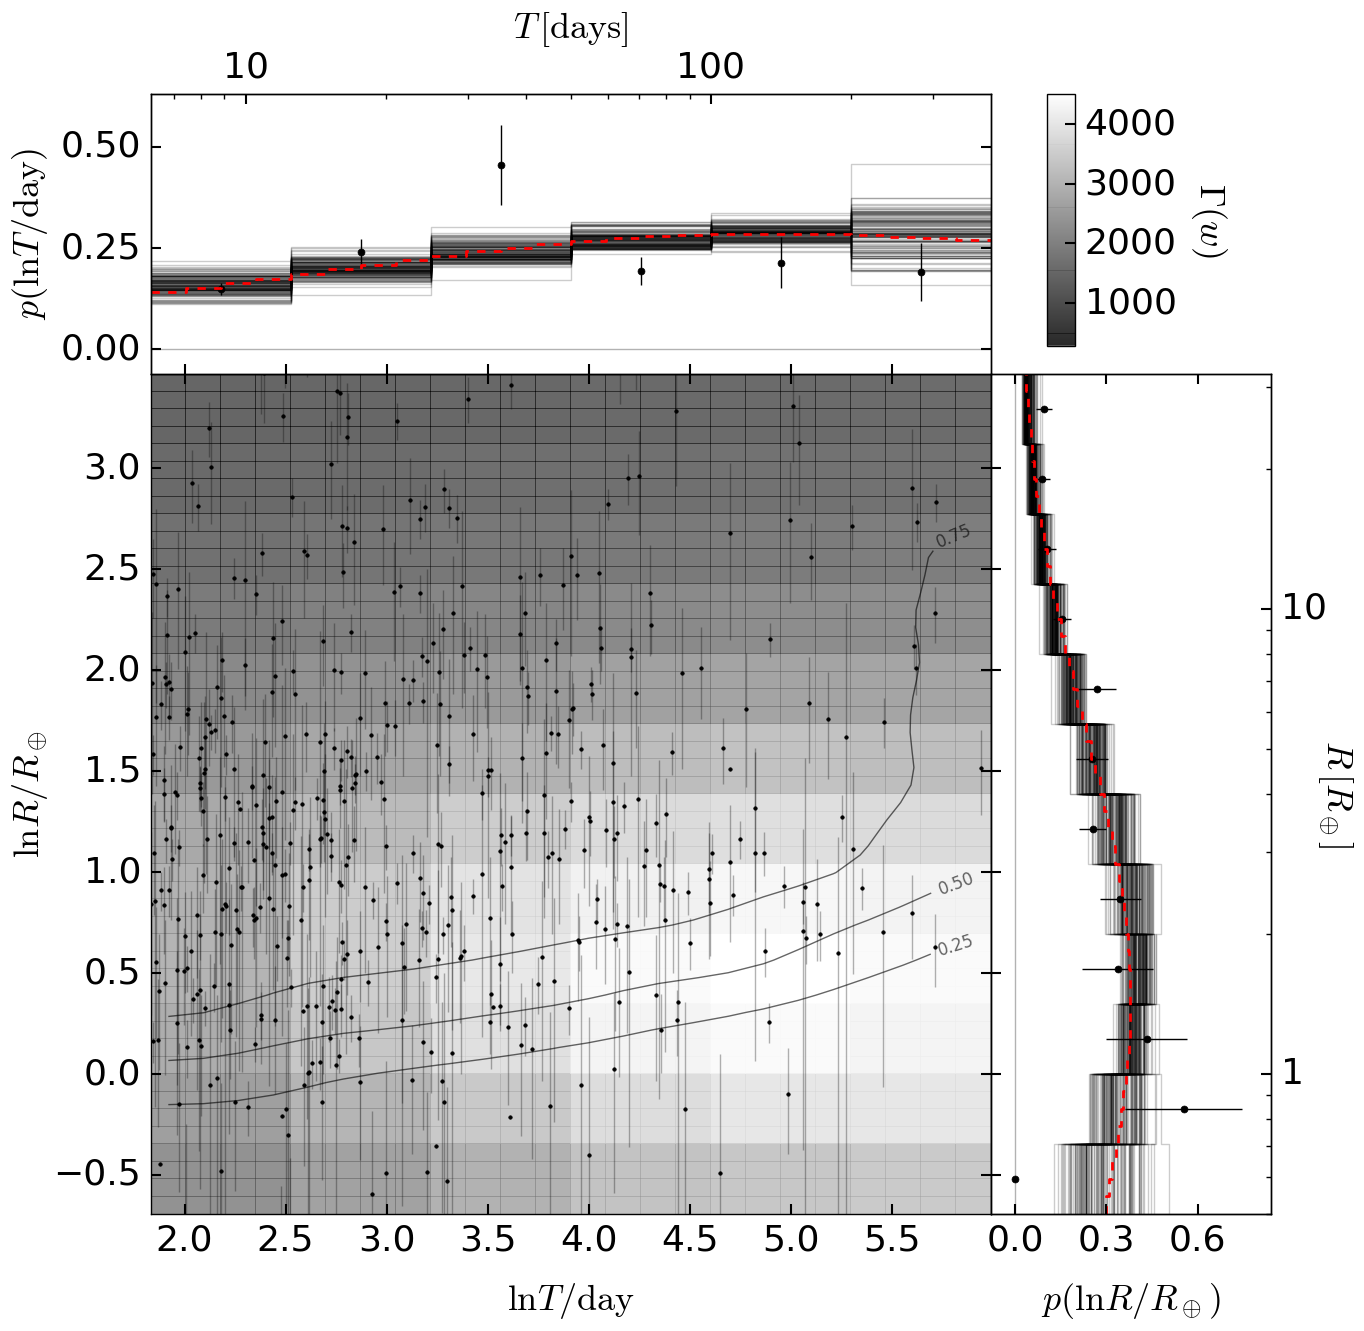

In [54]:
data = loadtxt('data/dfm-exopop-results-7568693/simulated/catalog-a/catalog.txt') # period, radius, radius err
catalog = c_[data[:, 0], normal(data[:, 1], data[:, 2])]
err=c_[zeros(len(data)), data[:,2]]
rerr = [log(catalog[:, 1]) - log(catalog[:, 1]-err[:, 1]),
        log(catalog[:, 1]+err[:, 1]) - log(catalog[:, 1])] # radius error
err = [0, rerr] # period and radius errors
cat, _, truth = pickle.load(open("data/smooth.cat.pkl", 'rb')) # load catalog

fig1 = pop.plot_2d(samples.reshape(len(samples), (len(bins[0])-1)*(len(bins[1])-1))[::50], censor=censor, catalog=log(catalog),
                   err=err, true=truth, labels=labels, top_axes=top_axes, literature=literature)

In [55]:
rates = pop.get_lnrate(samples.reshape(len(samples), (len(bins[0])-1)*(len(bins[1])-1)), [log(365.), log(1.0)])
fracs = rates - log(nstar)
q = corner.quantile(fracs, [0.16, 0.5, 0.84])
e = diff(q)
Math(r"\ln\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}}".format(q[1], e[0], e[1]))

<IPython.core.display.Math object>

## Catalog B

In [57]:
with h5py.File("data/dfm-exopop-results-7568693/simulated/catalog-b/samples.h5") as f:
    samples = f["ln_occurrence_rate_samples"][:,:]
    hyper = f["hyperparameter_samples"][:,:]
    x = f["ln_period_bin_edges"][:]
    y = f["ln_radius_bin_edges"][:]

Hyperparameter values (2ln):
6.01043319603 - 0.957077333222 + 0.82307879839
1.10151284966 - 0.568064068363 + 0.616934961441
2.37554504953 - 0.592636448315 + 0.987688419399
-1.45555696009 - 0.322485876485 + 1.43411669934


Hyperparameter values (linear):
20.1905888638 - 7.67871296129 + 10.2798195666
1.73456458947 - 0.428884048379 + 0.626762809553
3.27976746402 - 0.841093772457 + 2.09447073238
0.482980750556 - 0.0719229409033 + 0.506359967591


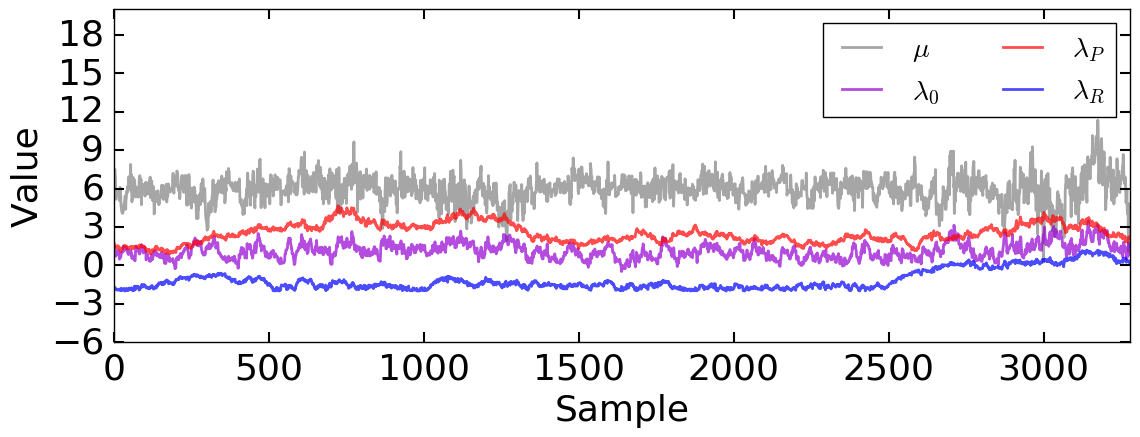

In [58]:
hypernames = ['$\mu$', '$\lambda_0$', '$\lambda_P$', '$\lambda_R$']
hypercolors = ['gray', 'darkviolet', 'red', 'blue']
figure(figsize=(12, 5))
for i in range(hyper.shape[1]):
    plot(hyper[:, i], label=hypernames[i], color=hypercolors[i], lw=2, alpha=0.7)
xlabel('Sample')
xlim([0, len(hyper)])
yticks(arange(-6, 20, 3))
ylim([-6, 20])
ylabel('Value')
legend(loc="best", fontsize=20, ncol=2)
tight_layout()

print("Hyperparameter values (2ln):")

q=array([corner.quantile(hyper[:, i], [.16, .50, .84]) for i in xrange(hyper.shape[1])])
e=diff(q)
print("\n".join(xmap("{0} - {1} + {2}".format, zip(q[:,1], e[:,0], e[:,1]))))

print("\n")
print("Hyperparameter values (linear):")

q=array([corner.quantile(exp(0.5*hyper[:, i]), [.16, .50, .84]) for i in xrange(hyper.shape[1])])
e=diff(q)
print("\n".join(xmap("{0} - {1} + {2}".format, zip(q[:,1], e[:,0], e[:,1]))))

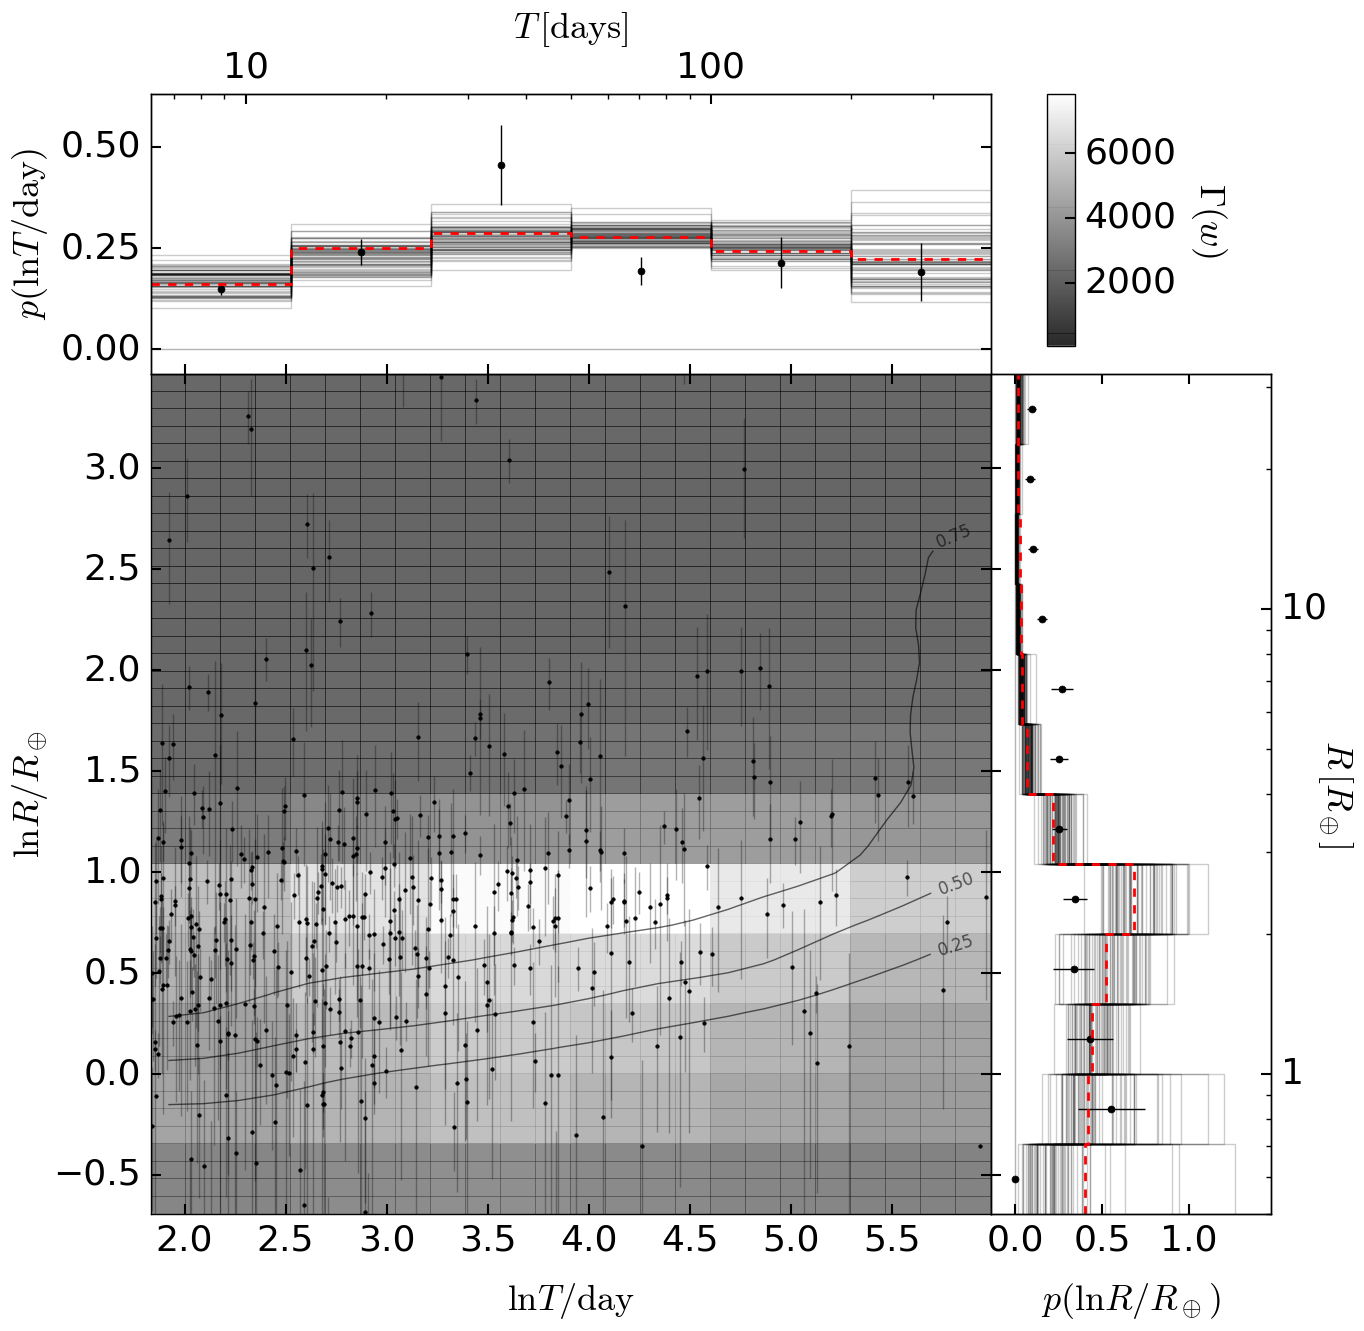

In [59]:
data = loadtxt('data/dfm-exopop-results-7568693/simulated/catalog-b/catalog.txt') # period, radius, radius err
catalog = c_[data[:, 0], normal(data[:, 1], data[:, 2])]
err=c_[zeros(len(data)), data[:,2]]
rerr = [log(catalog[:, 1]) - log(catalog[:, 1]-err[:, 1]),
        log(catalog[:, 1]+err[:, 1]) - log(catalog[:, 1])] # radius error
err = [0, rerr] # period and radius errors
cat, _, truth = pickle.load(open("data/rough.cat.pkl", 'rb')) # load catalog

fig1 = pop.plot_2d(samples.reshape(len(samples), (len(bins[0])-1)*(len(bins[1])-1))[::50], censor=censor, catalog=log(catalog),
                   err=err, true=truth, labels=labels, top_axes=top_axes, literature=literature)

In [60]:
rates = pop.get_lnrate(samples.reshape(len(samples), (len(bins[0])-1)*(len(bins[1])-1)), [log(365.), log(1.0)])
fracs = rates - log(nstar)
q = corner.quantile(fracs, [0.16, 0.5, 0.84])
e = diff(q)
Math(r"\ln\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}}".format(q[1], e[0], e[1]))

<IPython.core.display.Math object>

## Real Data (Petigura et al.)

In [62]:
with h5py.File("data/dfm-exopop-results-7568693/real/samples.h5") as f:
    samples = f["ln_occurrence_rate_samples"][:,:]
    hyper = f["hyperparameter_samples"][:,:]
    x = f["ln_period_bin_edges"][:]
    y = f["ln_radius_bin_edges"][:]

Hyperparameter values (2ln):
5.67874964633 - 1.53410463259 + 1.06773512306
1.62704946818 - 0.63000215649 + 0.722368650785
2.61987136158 - 0.763638420549 + 0.484174372443
-0.841039212297 - 0.507972254137 + 0.33428980894


Hyperparameter values (linear):
17.1050685011 - 9.16181853719 + 12.0679064105
2.25584524473 - 0.609556247045 + 0.981355729155
3.70593534171 - 1.17619429787 + 1.01507519701
0.65670550293 - 0.147297361013 + 0.119471492405


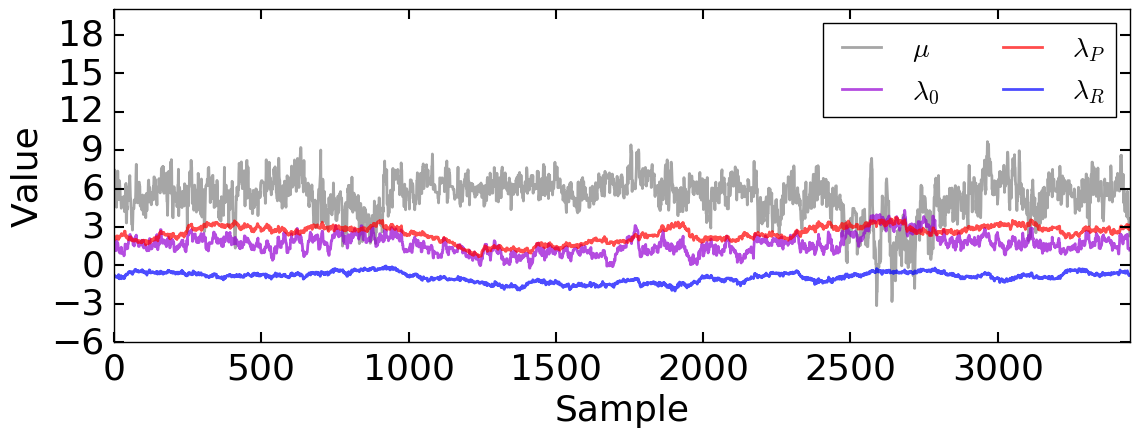

In [63]:
hypernames = ['$\mu$', '$\lambda_0$', '$\lambda_P$', '$\lambda_R$']
hypercolors = ['gray', 'darkviolet', 'red', 'blue']
figure(figsize=(12, 5))
for i in range(hyper.shape[1]):
    plot(hyper[:, i], label=hypernames[i], color=hypercolors[i], lw=2, alpha=0.7)
xlabel('Sample')
xlim([0, len(hyper)])
yticks(arange(-6, 20, 3))
ylim([-6, 20])
ylabel('Value')
legend(loc="best", fontsize=20, ncol=2)
tight_layout()

print("Hyperparameter values (2ln):")

q=array([corner.quantile(hyper[:, i], [.16, .50, .84]) for i in xrange(hyper.shape[1])])
e=diff(q)
print("\n".join(xmap("{0} - {1} + {2}".format, zip(q[:,1], e[:,0], e[:,1]))))

print("\n")
print("Hyperparameter values (linear):")

q=array([corner.quantile(exp(0.5*hyper[:, i]), [.16, .50, .84]) for i in xrange(hyper.shape[1])])
e=diff(q)
print("\n".join(xmap("{0} - {1} + {2}".format, zip(q[:,1], e[:,0], e[:,1]))))

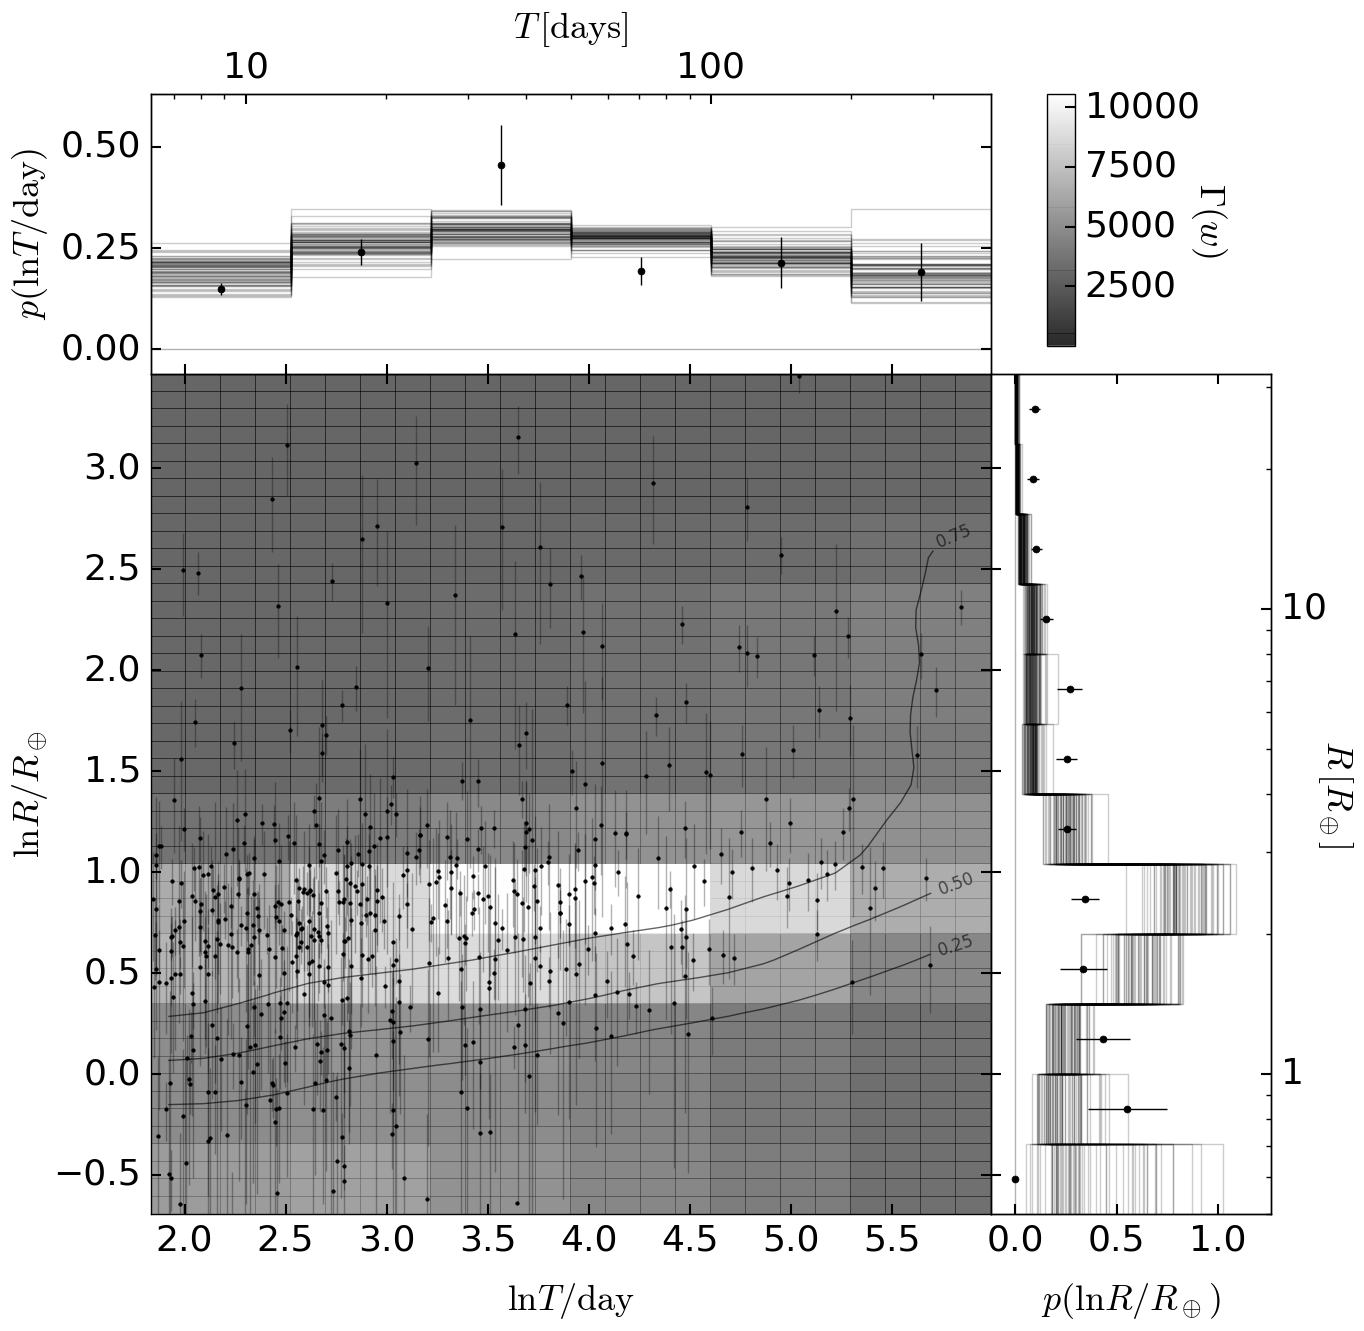

In [64]:
data = loadtxt('data/dfm-exopop-results-7568693/real/catalog.txt') # period, radius, radius err
catalog = c_[data[:, 0], normal(data[:, 1], data[:, 2])]
err=c_[zeros(len(data)), data[:,2]]
rerr = [log(catalog[:, 1]) - log(catalog[:, 1]-err[:, 1]),
        log(catalog[:, 1]+err[:, 1]) - log(catalog[:, 1])] # radius error
err = [0, rerr] # period and radius errors

fig1 = pop.plot_2d(samples.reshape(len(samples), (len(bins[0])-1)*(len(bins[1])-1))[::50], censor=censor, catalog=log(catalog),
                   err=err, true=None, labels=labels, top_axes=top_axes, literature=literature)

We can now compute and plot $\Gamma_\oplus$ from these realizations!

In [65]:
rates = pop.get_lnrate(samples.reshape(len(samples), (len(bins[0])-1)*(len(bins[1])-1)), [log(365.), log(1.0)])
fracs = rates - log(nstar)
a, b, c = corner.quantile(fracs, [0.16, 0.5, 0.84])
Math(r"\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}} \quad (\mathrm{{log}})".format(b, b-a, c-b))

<IPython.core.display.Math object>

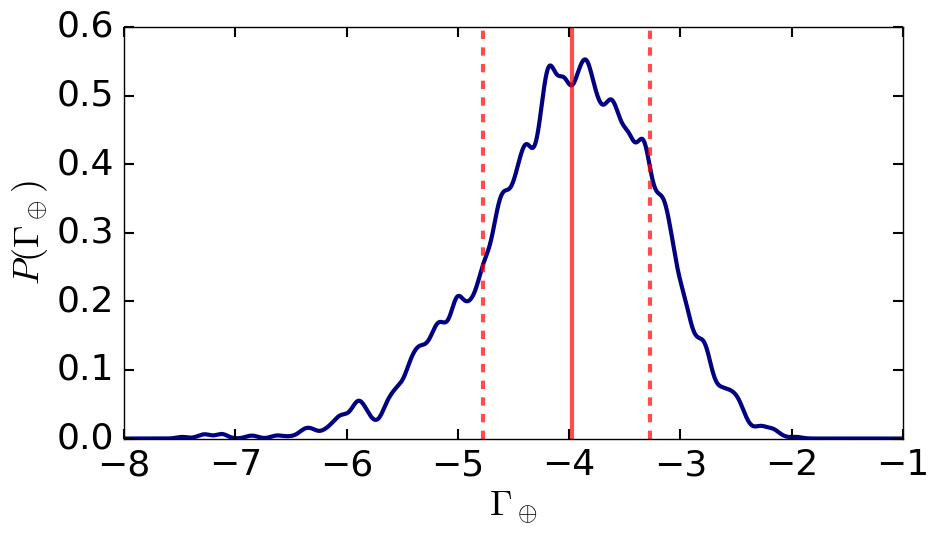

In [66]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(fracs[:,None]) # derive the underlying estimator
x = linspace(-8, -1, 5000)
log_dens = kde.score_samples(x[:,None]) # return results

# plotting
figure(figsize=(10, 6))
plot(x, exp(log_dens), color='navy', lw=3)
axvline(a, color='r', ls='--', alpha=0.7, lw=3)
axvline(b, color='r', ls='-', alpha=0.7, lw=3)
axvline(c, color='r', ls='--', alpha=0.7, lw=3)
xlabel('$\Gamma_\oplus$')
ylabel('$P(\Gamma_\oplus)$')
tight_layout()

In [67]:
al, bl, cl = corner.quantile(exp(fracs), [0.16, 0.5, 0.84])
Math(r"\Gamma_\oplus = {0:.3f} _{{-{1:.3f}}} ^{{+{2:.3f}}} \quad (\mathrm{{linear}})".format(bl, bl-al, cl-bl))

<IPython.core.display.Math object>

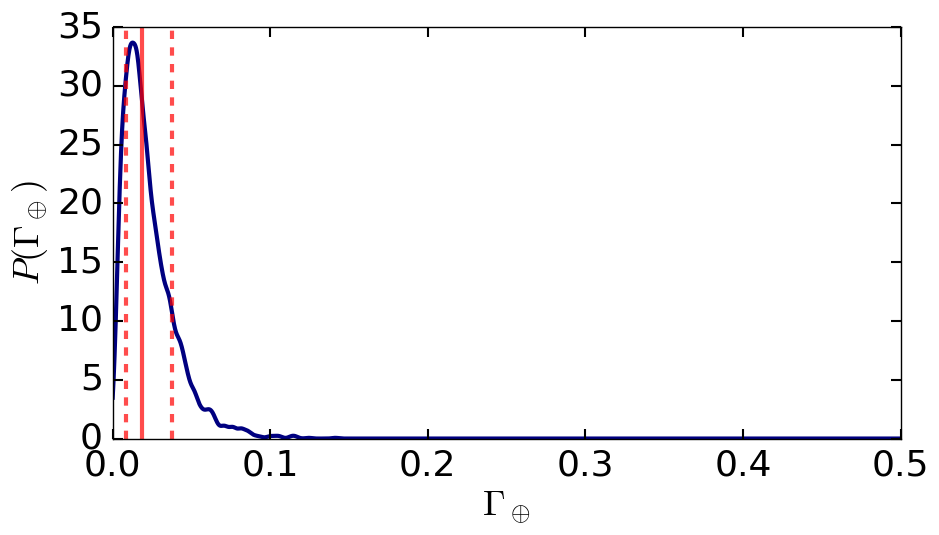

In [68]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.002).fit(exp(fracs[:,None])) # derive the underlying estimator
x = linspace(0, 0.5, 5000)
log_dens = kde.score_samples(x[:,None]) # return results

# plotting
figure(figsize=(10, 6))
plot(x, exp(log_dens), color='navy', lw=3)
axvline(al, color='r', ls='--', alpha=0.7, lw=3)
axvline(bl, color='r', ls='-', alpha=0.7, lw=3)
axvline(cl, color='r', ls='--', alpha=0.7, lw=3)
xlabel('$\Gamma_\oplus$')
ylabel('$P(\Gamma_\oplus)$')
tight_layout()

# Final Comparison

We plot all of our calculations together in one final image.

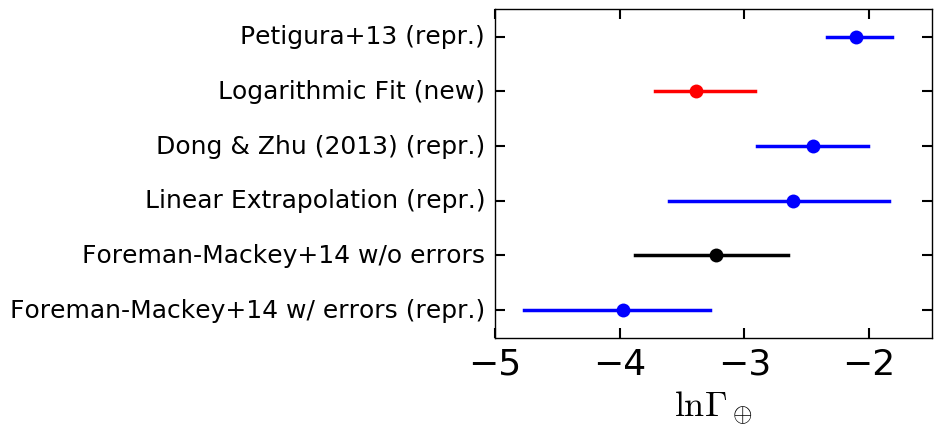

In [69]:
from matplotlib.ticker import MaxNLocator

values = [
    ("Petigura+13 (repr.)", q1[1], e1[1], e1[0], 'blue'),
    ("Logarithmic Fit (new)", q2[1], e2[1], e2[0], 'red'),
    ("Dong & Zhu (2013) (repr.)", q4[1], e4[1], e4[0], 'blue'),
    ("Linear Extrapolation (repr.)", q3[1], e3[1], e3[0], 'blue'),
    ("Foreman-Mackey+14 w/o errors", 0.0397591956934, 0.0309881584307, 0.0190620520124, 'black'),
    ("Foreman-Mackey+14 w/ errors (repr.)", bl, cl-bl, bl-al, 'blue')
]

fig = figure(figsize=(10, 5))
for i, v in enumerate(values):
    plot(log(v[1]), i, "o", color=v[4], markeredgecolor='none', markersize=10)
    plot(log([v[1]+v[2], v[1]-v[3]]), [i, i], color=v[4], lw=2.5)

gca().set_yticklabels([""] + [v[0] for v in values],fontsize=18)
xlabel(r"$\ln\Gamma_\oplus$")
fig.subplots_adjust(left=0.48, bottom=0.17, right=0.97, top=0.98)
ylim(len(values)-.5, -0.5)
gca().xaxis.set_major_locator(MaxNLocator(5))
tight_layout()